# Milestone 3: Investigate Project Questions

<hr style="clear:both">

This notebook illustrates the process we employed with the data to address the selected question from P2. Please feel free to refer to our external script for insights into certain steps involved in enriching, retrieving, and processing data. We utilized multiple APIs in this process, though they are not explicitly detailed here due to their relative complexity and their lack of relevance to P3.

**Project Mentor:** [Aoxiang Fan](https://people.epfl.ch/aoxiang.fan) ([Email](mailto:aoxiang.fan@epfl.ch))
**Authors:** [Luca Carroz](https://people.epfl.ch/emilie.carroz), [David Schroeter](https://people.epfl.ch/david.schroeter), [Xavier Ogay](https://people.epfl.ch/xavier.ogay), [Joris Monnet](https://people.epfl.ch/joris.monnet), [Paulo Ribeiro de Carvalho](https://people.epfl.ch/paulo.ribeirodecarvalho)

<hr style="clear:both">

## Import

In [1]:
import os
import warnings

# Import needed libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy.stats import pearsonr

from enrich_movie_data import create_enhanced_movie_dataset
from enrich_music_data import create_music_composers_dataset
from question_script.question_helper import extract_composers_data

# Load autoreload extension
%load_ext autoreload
%autoreload 2

## Create dataset

### Enrich the movies dataset

In [2]:
# If the dataset is not already created, create it
if not os.path.exists('dataset/clean_enrich_movies.pickle'):
    create_enhanced_movie_dataset()

### Create the composer dataset

In [3]:
# If the dataset is not already created, create it
if not os.path.exists('dataset/spotify_composers_dataset.pickle'):
    create_music_composers_dataset()

### Create the music related dataset

In [4]:
from enrich_with_spotify_data import create_musics_dataset

# If the dataset is not already created, create it
if (not os.path.exists('dataset/movie_album_and_revenue.pickle')
        or not os.path.exists('dataset/movie_album_and_revenue_with_track_ids.pickle')
        or not os.path.exists('dataset/album_id_and_musics.pickle')):
    create_musics_dataset()

## Load Data

Section to load data. Check that all datasets are already computed or downloaded, if not please read `README.md` and follow steps for its creation.

In [5]:
# Root where all dataset are store
datasets_path = 'dataset'

# Load dataset used to answer following question
spotify_composers_dataset = pd.read_pickle(os.path.join(datasets_path, 'spotify_composers_dataset.pickle'))
clean_enrich_movies = pd.read_pickle(os.path.join(datasets_path, 'clean_enrich_movies.pickle'))
location_to_country = pd.read_csv(os.path.join(datasets_path, 'mapping_locations_to_country.csv'))

## Question 1

Which are the most frequent music genre appearing in movies ?

In [6]:
# Create dataframe to map composers to movies
map_composers_to_movies = extract_composers_data(clean_enrich_movies)[['name', 'c_name', 'box_office_revenue']]

# Rename columns names to avoid unclear merging
map_composers_to_movies.columns = ['m_name', 'c_name', 'box_office_revenue']

# Merge movies to spotify dataframe and select wanted attributes
movie_music_genre_df = pd.merge(left=spotify_composers_dataset,
                                right=map_composers_to_movies,
                                left_on='name',
                                right_on='c_name',
                                how='inner')


movie_in_revenue_range = movie_music_genre_df.box_office_revenue.apply(lambda r: True if 0 <= r <= int(1e12) else False)
selected_movie_music_genre_df = movie_music_genre_df[movie_in_revenue_range]

movies_with_info = selected_movie_music_genre_df.genres.apply(lambda g: False if not g else True)  # check if g is empty
df = selected_movie_music_genre_df[movies_with_info]

# Initialize the new database
genre_distribution = pd.DataFrame(
    columns=['genre', 'count']
)
# Set the index to be unique (pair of ids)
genre_distribution.set_index(['genre'], inplace=True)

# Retrieve all genre that exist in the df
genres_dict = dict()
for _, genres in df.genres.items():
    for genre in genres:
        if genre in genres_dict.keys():
            genres_dict[genre] += 1
        else:
            genres_dict[genre] = 1

genre_count = pd.DataFrame(list(genres_dict.items()), columns=['genre', 'count']).sort_values(by='count', ascending=False)

genre_count

,genre,count
2,soundtrack,2725
18,orchestral soundtrack,1545
12,classic soundtrack,1321
21,british soundtrack,597
3,french soundtrack,255
...,...,...
48,ye ye,1
358,irish classical,1
357,celtic harp,1
356,women's music,1


## Question 2

What is the average composer's age at their :
   - first movie appearance ?
   - biggest box office revenue ?

### Average composer's age at their first movie appearance

In [7]:
composer_age_fst_movie = clean_enrich_movies.copy()

# Get composers, and only keep first row as we are interested in composers attributes which have been duplicated
# in each group, so only need first one
composer_age_fst_movie = extract_composers_data(composer_age_fst_movie, True).apply(lambda row: row.iloc[0])[
    ['c_birthday', 'c_date_first_appearance']]

composer_age_fst_movie.dropna(subset=['c_birthday', 'c_date_first_appearance'], inplace=True)

composer_age_fst_movie[['c_age_first_appearance_days', 'c_age_first_appearance_years']] = \
    composer_age_fst_movie.apply(lambda row: ((row['c_date_first_appearance'] - row['c_birthday']).days,
                                              (row['c_date_first_appearance'] - row['c_birthday']).days / 365.25),
                                 axis='columns', result_type='expand')

# Some composers have weird birthdate, which result in first appearance years being negative, so only
# take positive values
composer_age_fst_movie.query('c_age_first_appearance_years > 0', inplace=True)

# Exclude composers that are over 100 years old, not directly related to movie industry
composer_age_fst_movie.query('c_age_first_appearance_years < 100', inplace=True)

composer_age_fst_movie_days, composer_age_fst_movie_years = composer_age_fst_movie.c_age_first_appearance_days.mean(), composer_age_fst_movie.c_age_first_appearance_years.mean()

print("The average age of the composer at his first movie is:\n"
      f"\t- {composer_age_fst_movie_years:.3f} years\n"
      f"\t- {composer_age_fst_movie_days:.3f} days")

The average age of the composer at his first movie is:
	- 34.198 years
	- 12490.663 days


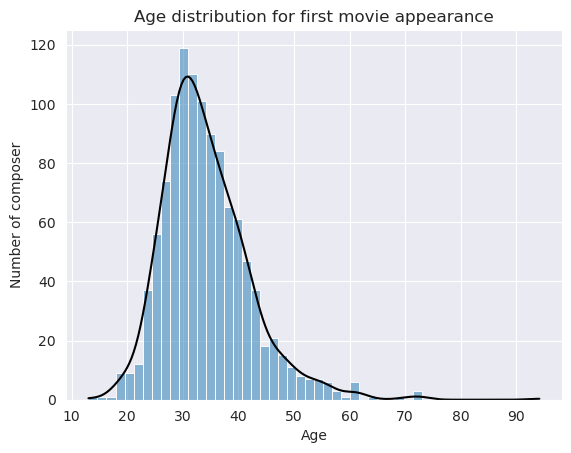

In [8]:
age_fst_appearance_years = composer_age_fst_movie['c_age_first_appearance_years']

# Plot the histogram of composer age at his first movie appearance
ax = sns.histplot(age_fst_appearance_years, bins=50, kde=True)
ax.lines[0].set_color('black')
plt.title('Age distribution for first movie appearance')
plt.ylabel('Number of composer')
plt.xlabel('Age')
plt.show()

### Average composer's age at their biggest box office revenue

In [9]:
composer_age_prime = clean_enrich_movies.copy()

composer_age_prime = extract_composers_data(composer_age_prime, True)

composer_age_prime = composer_age_prime.apply(
    lambda df_by_id: df_by_id.sort_values(by='box_office_revenue', ascending=False).iloc[0])

composer_age_prime['release_date'] = pd.to_datetime(composer_age_prime.release_date)

composer_age_prime.dropna(subset=['c_birthday', 'release_date'], inplace=True)

# TO exclude composers such as Vivaldi or Mozart that are too old to be meaningful
composer_age_prime.query('c_birthday > 1900', inplace=True)

composer_age_prime[['c_age_highest_revenue_days', 'c_age_highest_revenue_years']] = \
    composer_age_prime.apply(lambda row: ((row['release_date'] - row['c_birthday']).days,
                                          (row['release_date'] - row['c_birthday']).days / 365.25),
                             axis='columns', result_type='expand')

# Some composers have weird birthdate, which result in age at highest revenue years being negative, so only
# take positive values
composer_age_prime.query('c_age_highest_revenue_years > 0', inplace=True)

composer_age_prime_days, composer_age_prime_years = composer_age_prime.c_age_highest_revenue_days.mean(), composer_age_prime.c_age_highest_revenue_years.mean()

print("The average age of the composer at his highest box office revenue is:\n"
      f"\t- {composer_age_prime_years:.3f} years\n"
      f"\t- {composer_age_prime_days:.3f} days")

The average age of the composer at his highest box office revenue is:
	- 42.043 years
	- 15356.133 days


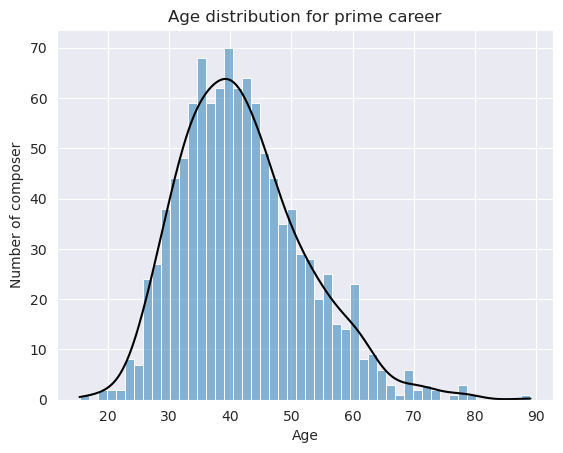

In [10]:
age_fst_appearance_years = composer_age_prime['c_age_highest_revenue_years']

# Plot
ax = sns.histplot(age_fst_appearance_years, bins=50, kde=True)
ax.lines[0].set_color('black')
plt.title('Age distribution for prime career')
plt.ylabel('Number of composer')
plt.xlabel('Age')
plt.show()

## Question 3

How the top composers' career progress over the years ?

In [11]:
# Prepare data for question 3:
# - Rename columns
# - Filter by top composers
# - Keep only the columns we need : composer_id, composer_name, release_date, box_office_revenue

# Drop all the columns which are not release date and composer
df_q3 = clean_enrich_movies[['release_date', 'composers', 'box_office_revenue']].copy()

# Drop all the rows which have no composer or no release date
df_q3.dropna(inplace=True)

df_q3 = extract_composers_data(df_q3, False)

df_q3 = df_q3[['release_date', 'c_id', 'c_name', 'box_office_revenue']]

df_q3_movie_renamed = df_q3.rename(
    columns={'release_date': 'release_year', 'c_id': 'composer_id', 'c_name': 'composer_name'})

display(df_q3_movie_renamed.head())


,release_year,composer_id,composer_name,box_office_revenue
0,2009,1729,James Horner,2.782275e+09
1,1997,1729,James Horner,2.185372e+09
2,2012,37,Alan Silvestri,1.511758e+09
3,2011,2949,Alexandre Desplat,1.328111e+09
4,2013,6041,Brian Tyler,1.215577e+09


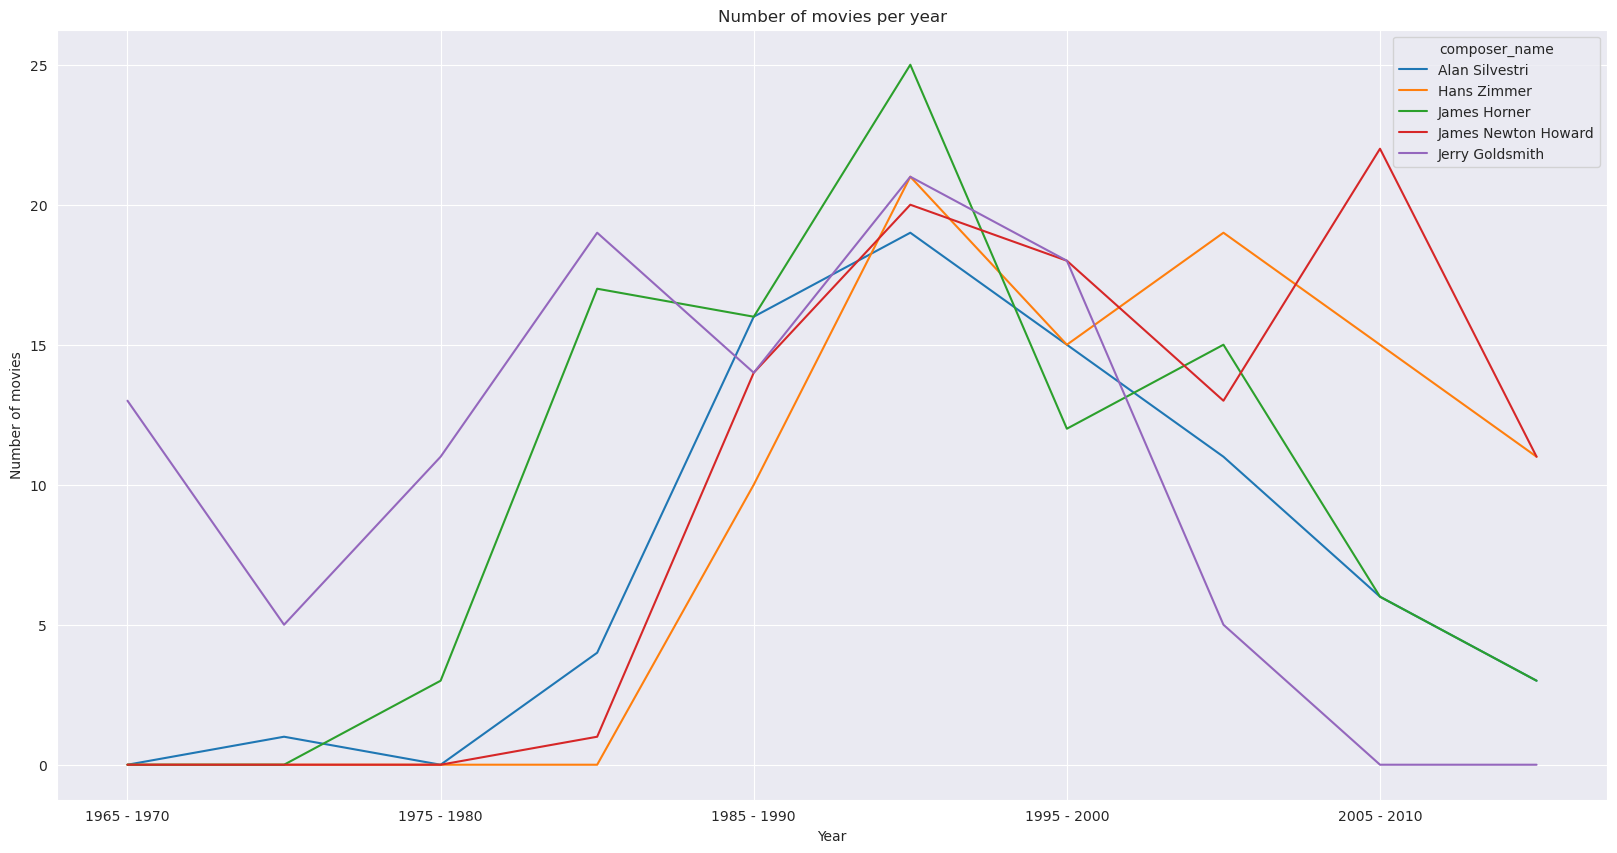

In [12]:
# Keep the 5 composers with the highest number of movies they contributed to
top_composers = df_q3_movie_renamed['composer_id'].value_counts().head(5).index

# Keep only the top 5 composers with their index
movie_grouped_by_top_composer = df_q3_movie_renamed[df_q3_movie_renamed['composer_id'].isin(top_composers)]

# Change years to int
movie_grouped_by_top_composer.loc[:, 'release_year'] = movie_grouped_by_top_composer['release_year'].astype(int)

# Define bins for years (5 years interval on the plot)
bins = np.arange(movie_grouped_by_top_composer['release_year'].min(),
                 movie_grouped_by_top_composer['release_year'].max() + 1, 5)

with warnings.catch_warnings():
    # Ignore warning about the use of cut
    warnings.filterwarnings("ignore")
    # Add a new column 'year_bin' to the DataFrame, indicating which bin each year falls into
    movie_grouped_by_top_composer['year_bin'] = pd.cut(movie_grouped_by_top_composer['release_year'], bins)

    # Convert the bins to strings
    movie_grouped_by_top_composer['year_bin'] = movie_grouped_by_top_composer['year_bin'].apply(
        lambda x: str(x).replace('(', '')
        .replace(']', '')
        .replace(',', ' -')
    )
# Group by composer and year bin, count the number of movies
movie_counts = movie_grouped_by_top_composer.groupby(['composer_name', 'year_bin'], observed=False).size()

# Unstack the 'composer_name' level to create a DataFrame
movie_counts_df = movie_counts.unstack(level='composer_name')

# Plot the data
movie_counts_df.plot(kind='line', figsize=(20, 10))

# Set the title and labels
plt.title('Number of movies per year')
plt.xlabel('Year')
plt.ylabel('Number of movies')

plt.show()

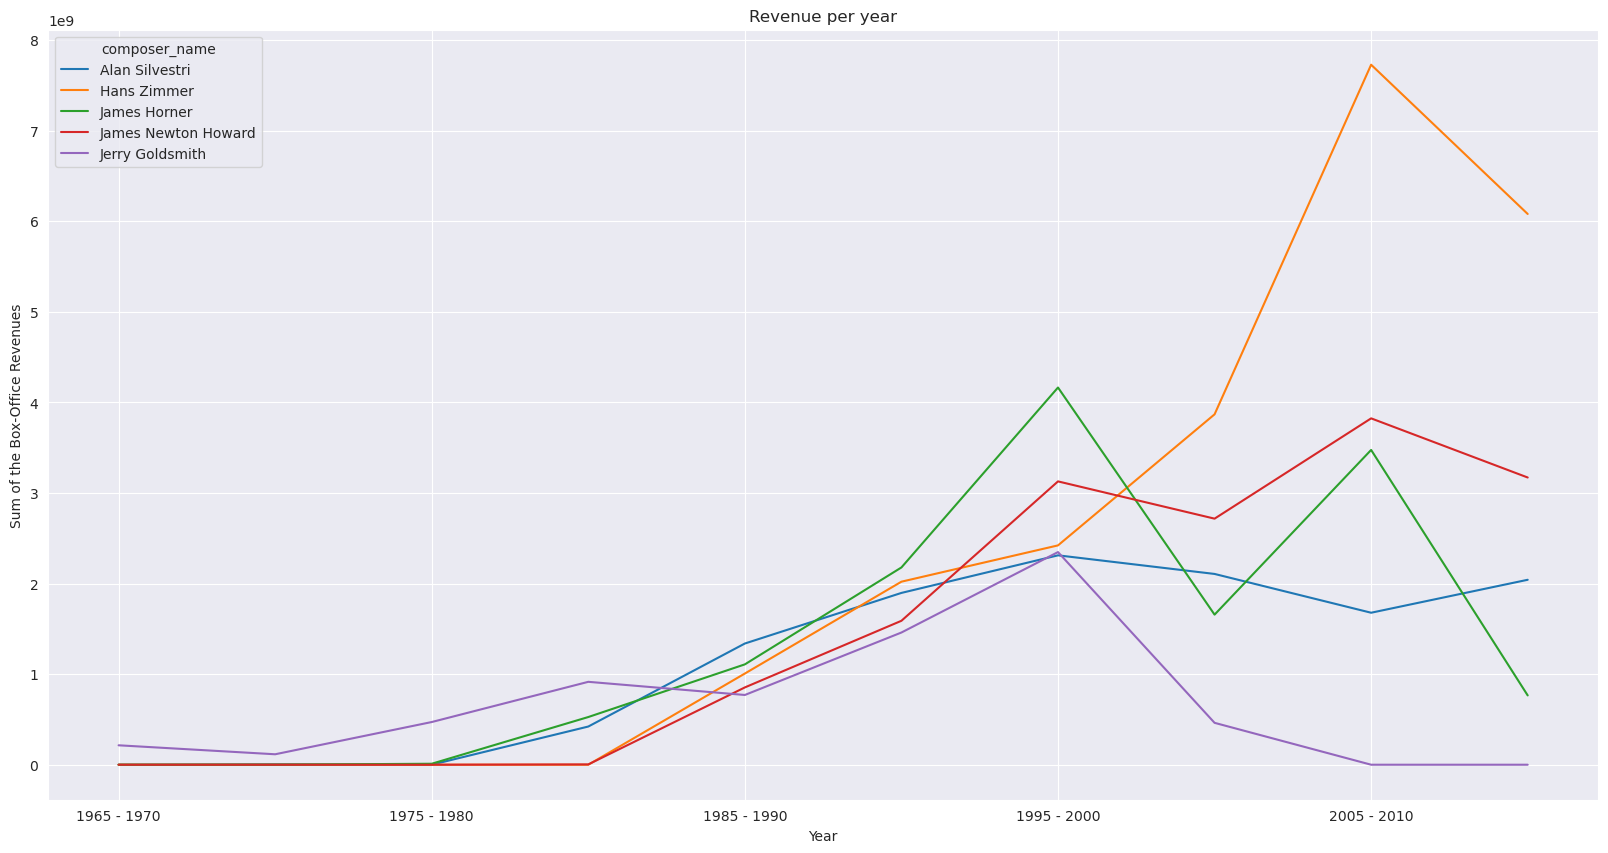

In [13]:
# Plot the evolution of the revenue for the film per year for the top composers
movie_revenue = movie_grouped_by_top_composer.groupby(['composer_name', 'year_bin'], observed=False)[
    'box_office_revenue'].sum()

# Unstack the 'composer_name' level to create a DataFrame
movie_revenue_df = movie_revenue.unstack(level='composer_name')

# Plot the data
movie_revenue_df.plot(kind='line', figsize=(20, 10))
plt.title('Revenue per year')
plt.xlabel('Year')
plt.ylabel('Sum of the Box-Office Revenues')
plt.show()

## Question 4

Where do composers come from ?

*Note: This question used OpenAI API to create a mapping from location to country. Indeed, each composer has a place of birth given by its location, but we are interested here by their country origin. Then, we gave to GPT-4 the task to give back a mapping for all possible locations from our dataframe. Please read `README.md` and `location_to_country_openai_api.py` for more information.*

In [14]:
# Create dataframe to map composers to movies with their place_of_birth
map_composers_to_movies = extract_composers_data(clean_enrich_movies)[['name', 'c_name', 'c_place_of_birth']]

# Rename columns names to avoid unclear merging
map_composers_to_movies.columns = ['m_name', 'c_name', 'c_place_of_birth']

# Merge composer information with movies to retrieve the popularity
composer_place_of_birth_df = pd.merge(
    left=spotify_composers_dataset,
    right=map_composers_to_movies,
    left_on='name',
    right_on='c_name',
    how='inner'
)[['c_name', 'c_place_of_birth', 'popularity']].drop_duplicates()  # note: few rows were duplicate

# Delete rows (composers) where we do not have the place of birth (i.e. None value)
composer_place_of_birth_df = composer_place_of_birth_df.query('c_place_of_birth.notna()')

# Compute the number of composer per location within the selected range of composer's popularity
movie_in_revenue_range = composer_place_of_birth_df.popularity.apply(lambda p: True if 0 <= p <= 100 else False)
number_composer_per_location = composer_place_of_birth_df[movie_in_revenue_range].groupby('c_place_of_birth').count()[
    "c_name"]

# For plot reasons, map all locations to its corresponding country and count again the number of composer
number_composer_per_country = pd.merge(
    left=number_composer_per_location,
    right=location_to_country,
    left_on='c_place_of_birth',
    right_on='location',
    how='outer'
).groupby('country').count()["location"]


[link](https://plotly.com/python/builtin-colorscales/) to see different colors.

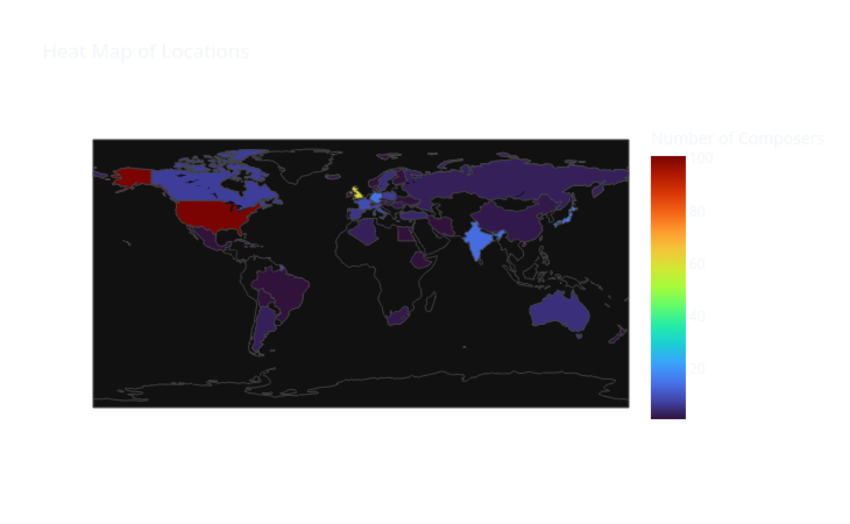

In [15]:
fig = px.choropleth(data_frame=number_composer_per_country.reset_index(),
                    locations='country',
                    locationmode='country names',
                    color='location',
                    color_continuous_scale='peach',  # can change color, click link in markdown just above
                    title='Heat Map of Locations',
                    labels={'location': 'Number of Composers'}
                    )
# Fix the layout template
fig.update_layout(template='plotly')

# Show the figure
# fig.show()

# We use code for this because markdown is not rendering properly on browser (https://github.com/jupyter/notebook/issues/3278)
from IPython.display import Image

Image(filename='assets/img/world_map.png')

## Question 5

Does composer's gender matter ?

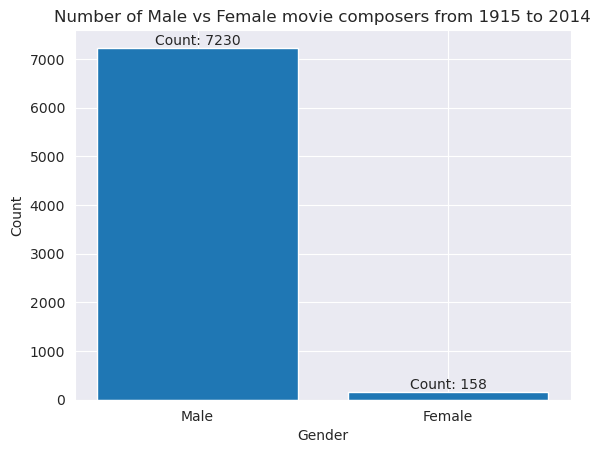

In [16]:
# Get all movie composers
composers = extract_composers_data(clean_enrich_movies)

# Drop the rows with 'undefined' gender
cleaned_composers = composers[composers.c_gender != 0].copy()
# Map the gender values to meaningful strings
cleaned_composers['c_gender'].replace(to_replace={1: 'Female', 2: 'Male'}, inplace=True)

# Count the occurrences of each gender
gender_counts = cleaned_composers['c_gender'].value_counts()

# Create a bar chart
fig, ax = plt.subplots()
bars = ax.bar(gender_counts.index, gender_counts)

# Set plot title and labels
ax.set_title("Number of Male vs Female movie composers from 1915 to 2014")
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

# Add information as text labels above the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f'Count: {yval}', ha='center', va='bottom')

# Show the plot
plt.show()

Let's see how this ratio evolved over the years

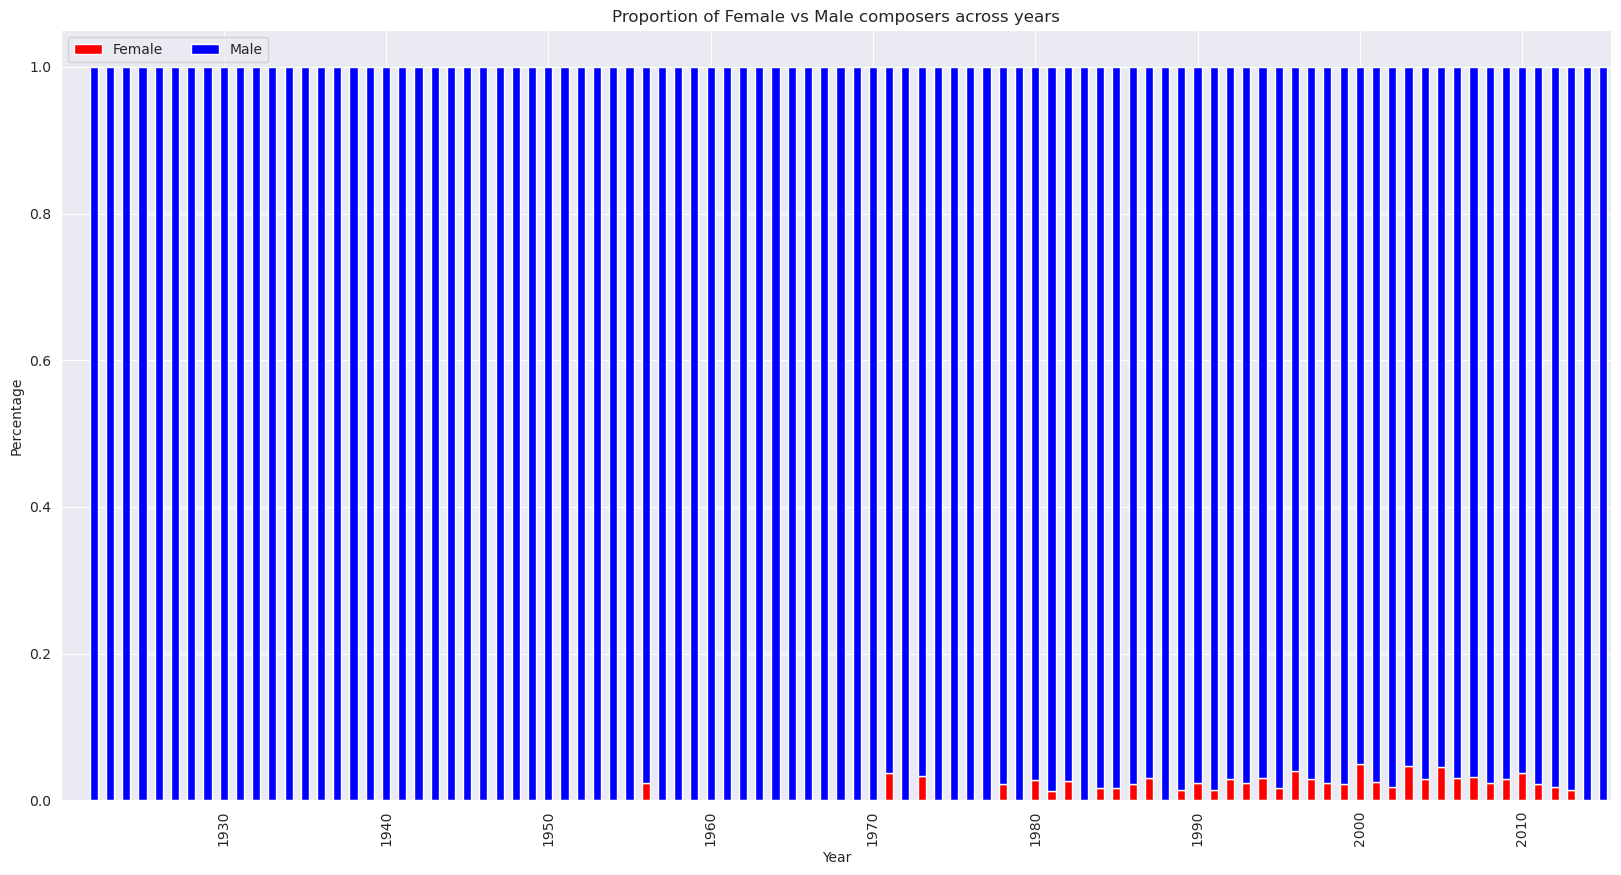

In [17]:
# Dataframe containing the number of composers for each year, grouped by their gender
gender_prop_by_year = pd.crosstab(index=cleaned_composers['release_date'], columns=cleaned_composers['c_gender'],
                                  normalize='index')

# Plot the dataframe
gender_prop_by_year.plot(kind='bar', stacked=True, color=['red', 'blue'], figsize=(20, 10))
plt.xticks(np.arange(-2, 96, 10))
plt.title('Proportion of Female vs Male composers across years')
plt.legend(loc="upper left", ncol=2)
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.show()

## Question 6

Does having a personal website correlate with the composers' success ?

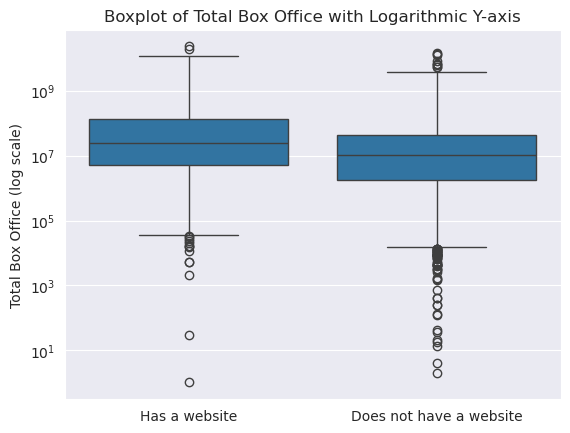

In [18]:
# Get each composer's website (if they have one) and drop the release date column, since it is not relevant
composers_website = extract_composers_data(clean_enrich_movies).drop(columns=['release_date', 'countries', 'genres'])

# Drop eventual duplicates
composers_website.drop_duplicates(inplace=True)
# Keep only the used columns
composers_website = composers_website[['c_id', 'box_office_revenue', 'c_homepage']]
# Map the homepage column to a boolean value
composers_website_agg = composers_website.groupby('c_id').agg(
    total_box_office=pd.NamedAgg(column='box_office_revenue', aggfunc='sum'),
    has_website=pd.NamedAgg(column='c_homepage',
                            aggfunc=lambda x: any(x.notna()))
).reset_index()

composers_website_agg['website'] = (composers_website_agg['has_website']
                                    .apply(lambda x: 'Has a website' if x else 'Does not have a website'))

# Create a boxplot with a logarithmic y-axis, with two boxplots
ax = sns.boxplot(x='website', y='total_box_office', data=composers_website_agg, log_scale=True)
ax.set_xlabel('')
ax.set_ylabel('Total Box Office (log scale)')
ax.set_title('Boxplot of Total Box Office with Logarithmic Y-axis')

# Show the plot
plt.show()

In [19]:
# Perform Pearson correlation test
correlation_coefficient, p_value = pearsonr(composers_website_agg['total_box_office'],
                                            composers_website_agg['has_website'])

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a significant correlation.")
    if correlation_coefficient > 0:
        print("The correlation is positive.")
    elif correlation_coefficient < 0:
        print("The correlation is negative.")
    else:
        print("There is no linear correlation, but there may be a non-linear relationship.")
else:
    print("There is no significant correlation.")

Pearson correlation coefficient: 0.11254597666265041
P-value: 2.3590172531645586e-08
There is a significant correlation.
The correlation is positive.


## Question 7

Is there a correlation between box office revenue and movie's playlist popularity ?

In [20]:


# Read the pickle files
df_album_id_musics = pd.read_pickle('dataset/album_id_and_musics.pickle')
df_movie_album_revenue = pd.read_pickle("dataset/movie_album_and_revenue.pickle")

# Drop the rows with missing values
df_movie_album_revenue = df_movie_album_revenue[~df_movie_album_revenue["album_id"].isna()]
df_movie_album_revenue.drop_duplicates(subset=['movie_name'], inplace=True)

# Drop the rows with missing values
empty = df_album_id_musics["track"].isna()
df_album_id_musics = df_album_id_musics[~empty]

df_album_id_musics.reset_index(inplace=True)
df_album_id_musics["popularity"] = df_album_id_musics["track"].apply(lambda x: x.popularity)

# Get the mean popularity for each album
pop_df = df_album_id_musics[['album_id', 'popularity']].groupby('album_id').mean()
pop_df = pop_df[~pop_df["popularity"].isna()]
pop_df.reset_index(inplace=True)

merged_df = pd.merge(left=df_movie_album_revenue, right=pop_df, left_on='album_id', right_on='album_id', how='inner')


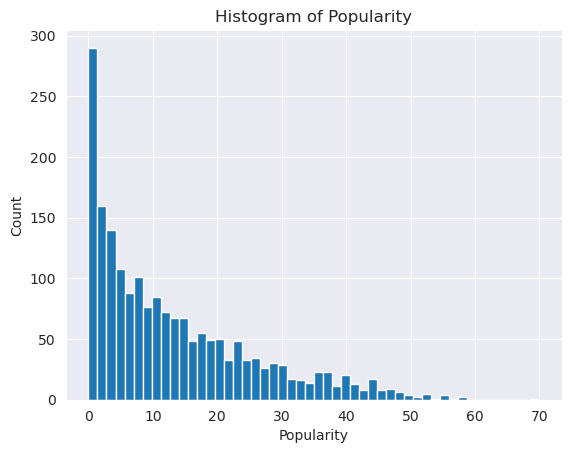

In [21]:
#q7.plot_popularity_histogram_matplt(pop_df)
# Create the histogram
plt.hist(pop_df['popularity'], bins=50)

# Set the title and labels
plt.title('Histogram of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')

# Show the plot
plt.show()

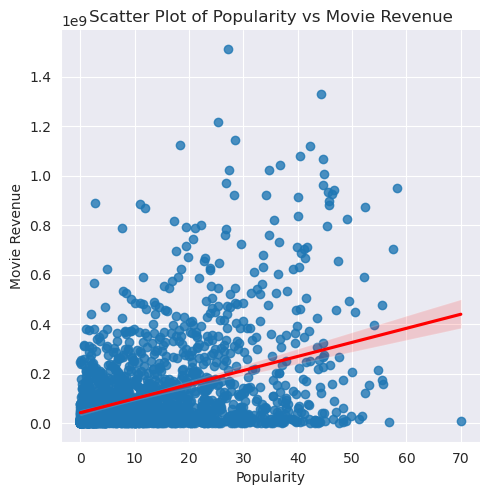

In [22]:
# Set movie revenue to float as it has been parsed as object
merged_df = merged_df.astype({'movie_revenue': 'float'})

sns.lmplot(x='popularity', y='movie_revenue', data=merged_df, fit_reg=True, scatter_kws={'alpha': 0.8},
           line_kws={'color': 'red'})

# Set title and labels
plt.title('Scatter Plot of Popularity vs Movie Revenue')
plt.xlabel('Popularity')
plt.ylabel('Movie Revenue')

# Show the plot
plt.show()

In [23]:
corr, _ = pearsonr(merged_df["popularity"], merged_df["movie_revenue"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.392


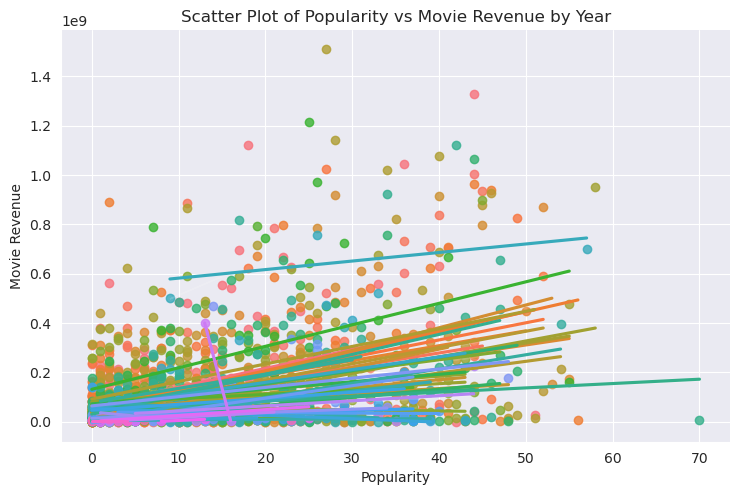

In [24]:
merged_df.dropna(inplace=True)
# drop row with 0 value
merged_df = merged_df[merged_df["movie_revenue"] > 0]
merged_df = merged_df[merged_df["popularity"] > 0]

# popularity and revenue cast as int
merged_df["popularity"] = merged_df["popularity"].astype(int)
merged_df["movie_revenue"] = merged_df["movie_revenue"].astype(int)

# Create a scatter plot using seaborn for better color handling and regression line
sns.lmplot(x='popularity', y='movie_revenue', hue='release_date', data=merged_df,
           aspect=1.5, fit_reg=True, scatter_kws={'alpha': 0.8}, legend=False, ci=0)

# Set title and labels
plt.title('Scatter Plot of Popularity vs Movie Revenue by Year')
plt.xlabel('Popularity')
plt.ylabel('Movie Revenue')

# Show the plot
plt.show()

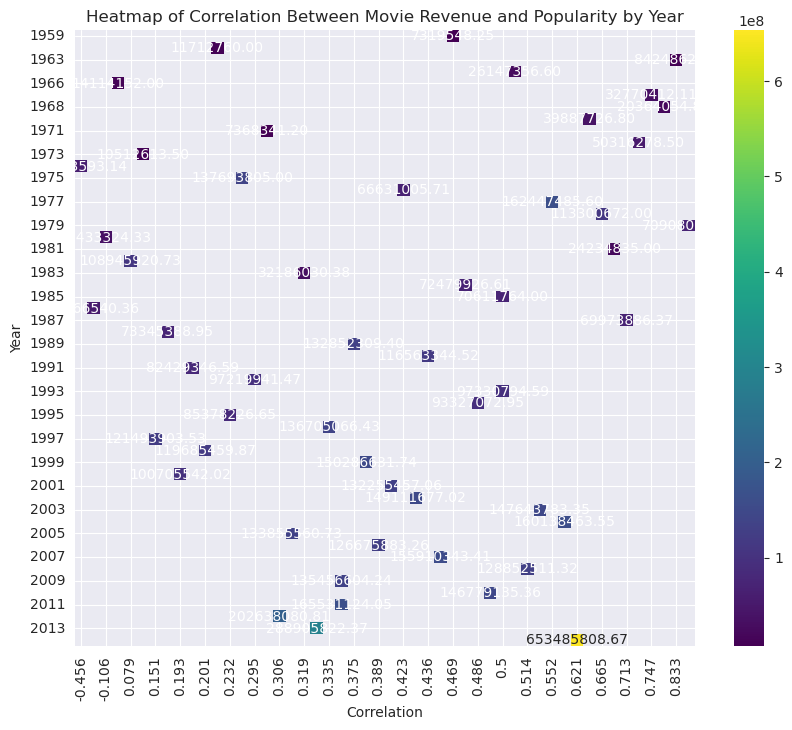

In [25]:
merged_df_modified = merged_df.copy()
merged_df_modified.dropna(inplace=True)

# drop row with 0 value
merged_df_modified = merged_df_modified[merged_df_modified["movie_revenue"] > 0]
merged_df_modified = merged_df_modified[merged_df_modified["popularity"] > 0]
merged_df_modified['release_date'] = merged_df_modified['release_date'].astype(int)
merged_df_modified = merged_df_modified[merged_df_modified["release_date"] > 1000]

# Group by year and calculate the correlation between 'movie_revenue' and 'popularity'
correlation_by_year = merged_df_modified.groupby('release_date')[['movie_revenue', 'popularity']].corr().iloc[0::2,
                      -1].reset_index()
mean_revenue_by_year = merged_df_modified.groupby('release_date')['movie_revenue'].mean().reset_index()

correlation_by_year['mean_revenue'] = mean_revenue_by_year['movie_revenue']

# Rename the columns for the heatmap
correlation_by_year.columns = ['year', 'drop', 'correlation', 'mean_revenue']
correlation_by_year = correlation_by_year.drop(columns='drop')
correlation_by_year.dropna(inplace=True)
correlation_by_year = correlation_by_year[correlation_by_year["correlation"] < 0.99]
correlation_by_year = correlation_by_year[correlation_by_year["correlation"] > -0.99]

correlation_by_year['year'] = correlation_by_year['year'].astype(int)
correlation_by_year['correlation'] = correlation_by_year['correlation'].astype(float)
correlation_by_year['mean_revenue'] = correlation_by_year['mean_revenue'].astype(float)

#round correlation
correlation_by_year['correlation'] = correlation_by_year['correlation'].apply(lambda x: round(x, 3))

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_by_year.pivot(index='year', columns='correlation', values='mean_revenue'), annot=True,
            fmt=".2f", cmap='viridis')

# Set the title and labels
plt.title('Heatmap of Correlation Between Movie Revenue and Popularity by Year')
plt.xlabel('Correlation')
plt.ylabel('Year')

# Show the plot
plt.show()